In [209]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp

In [210]:
# Geometry
L = 0.43 # m, reactor length
dz = 0.001 # m, grid size
n_nodes = int(L/dz) + 1 # number of grid points
z = np.linspace(0, L, n_nodes) # grid points

ID = 5.03e-3 # m, inner diameter
OD = 6.33e-3 # m, outer diameter
tkn = OD - ID # m, wall thickness

Ai = np.pi * ID**2 / 4 # m2, inner cross-sectional area
Ao = np.pi * OD**2 / 4 # m2, outer cross-sectional area
Aw = Ao - Ai # m2, wall cross-sectional area

pri = np.pi * ID # m, inner perimeter
pro = np.pi * OD # m, outer perimeter

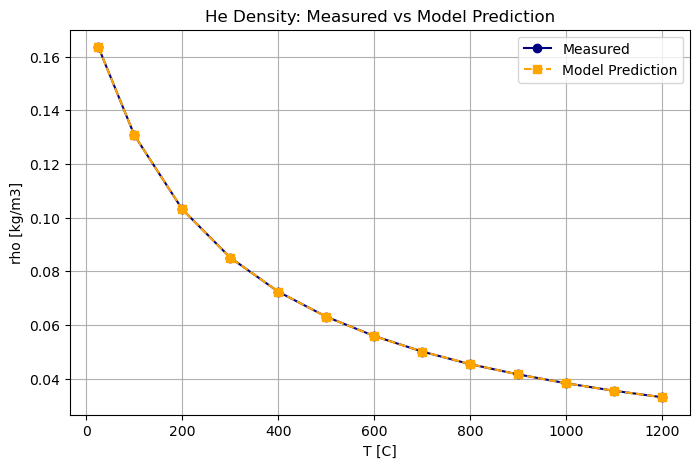

Text(0.5, 1.0, 'KanthalD Heat Capacity: Measured vs Model Prediction')

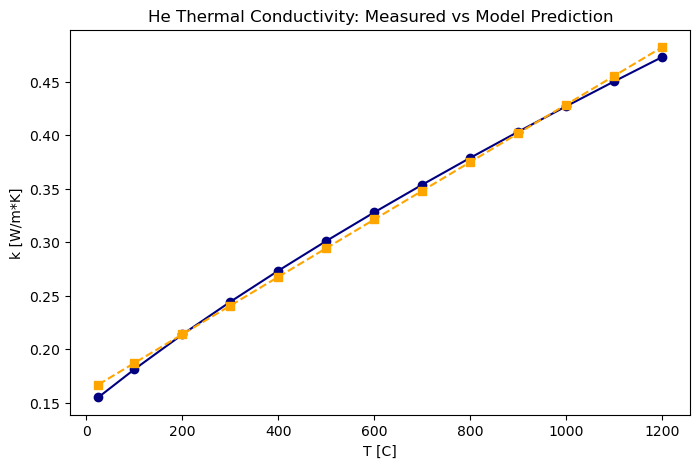

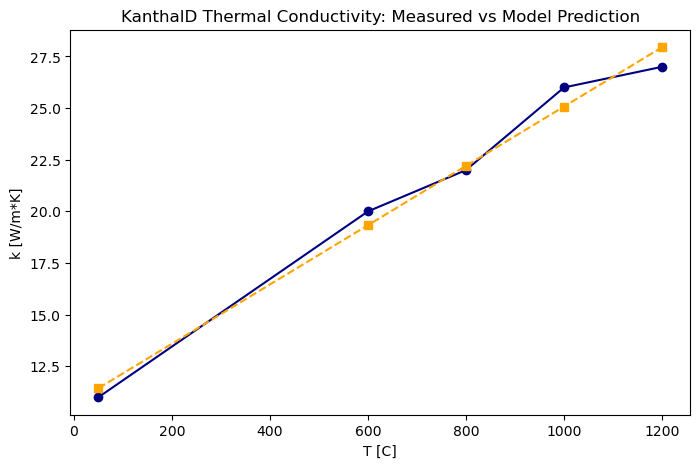

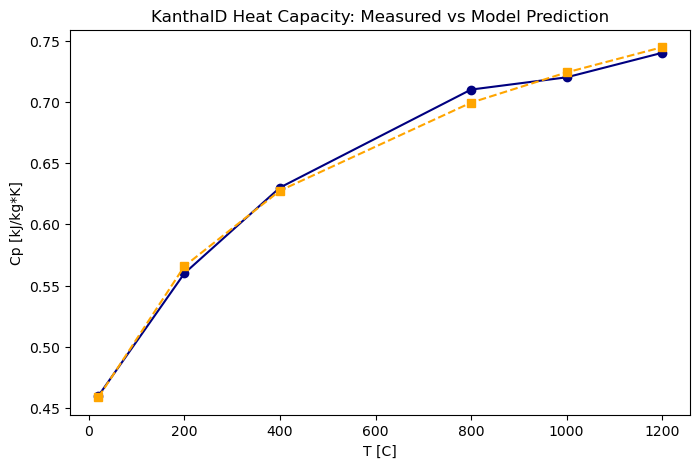

In [211]:
# Material properties
path_he = '../data/He_property.csv'
path_kt = '../data/KanthalD_property.csv'
df_he = pd.read_csv(path_he)
df_kt = pd.read_csv(path_kt)

# He molar weight
Mw_he = 4.0026 # g/mol

# He density
def rho_he_fit(T, a, b, c):
    return a / (b + T) + c
prho_he, _ = curve_fit(rho_he_fit, df_he['T [C]'], df_he['rho [kg/m3]'])
a_rho_he, b_rho_he, c_rho_he = prho_he
def rho_he(T):
    return a_rho_he / (b_rho_he + T) + c_rho_he
fitted_rho = rho_he(df_he['T [C]'])
plt.figure(figsize=(8,5))
plt.plot(df_he['T [C]'], df_he['rho [kg/m3]'], marker='o', linestyle='-', color='navy', label='Measured')
plt.plot(df_he['T [C]'], fitted_rho, marker='s', linestyle='--', color='orange', label='Model Prediction')
plt.xlabel('T [C]')
plt.ylabel('rho [kg/m3]')
plt.title('He Density: Measured vs Model Prediction')
plt.legend()
plt.grid(True)
plt.show()

# He heat capacity
Cp_he = 20.786 # J/mol/K, heat capacity of helium

# He thermal conductivity
def k_he_fit(T, a, b):
    return a*T + b
pk_he, _ = curve_fit(k_he_fit, df_he['T [C]'], df_he['Tc [W/m*K]'])
a_k_he, b_k_he = pk_he
def k_he(T):
    return a_k_he*T + b_k_he
fitted_k = k_he(df_he['T [C]'])
plt.figure(figsize=(8,5))
plt.plot(df_he['T [C]'], df_he['Tc [W/m*K]'], marker='o', linestyle='-', color='navy', label='Measured')
plt.plot(df_he['T [C]'], fitted_k, marker='s', linestyle='--', color='orange', label='Model Prediction')
plt.xlabel('T [C]')
plt.ylabel('k [W/m*K]')
plt.title('He Thermal Conductivity: Measured vs Model Prediction')

# kanthalD density
rho_kt = 7250 # kg/m3

# kanthalD thermal conductivity
def k_kt_fit(T, a, b):
    return a*T + b
df_kt_k = df_kt[df_kt['k [W/m*K]'].notna()]
pk_kt, _ = curve_fit(k_kt_fit, df_kt_k['T [C]'], df_kt_k['k [W/m*K]'])
a_k_kt, b_k_kt = pk_kt
def k_kt(T):
    return a_k_kt*T + b_k_kt
fitted_k_kt = k_kt(df_kt_k['T [C]'])
plt.figure(figsize=(8,5))
plt.plot(df_kt_k['T [C]'], df_kt_k['k [W/m*K]'], marker='o', linestyle='-', color='navy', label='Measured')
plt.plot(df_kt_k['T [C]'], fitted_k_kt, marker='s', linestyle='--', color='orange', label='Model Prediction')
plt.xlabel('T [C]')
plt.ylabel('k [W/m*K]')
plt.title('KanthalD Thermal Conductivity: Measured vs Model Prediction')

# kanthalD heat capacity
def Cp_kt_fit(T, a, b, c):
    return a*np.log(T + b) + c
df_kt_Cp = df_kt[df_kt['Cp [kJ/kg*K]'].notna()]
pk_kt, _ = curve_fit(Cp_kt_fit, df_kt_Cp['T [C]'], df_kt_Cp['Cp [kJ/kg*K]'])
a_Cp_kt, b_Cp_kt, c_Cp_kt = pk_kt
def Cp_kt(T):
    return (a_Cp_kt*np.log(T + b_Cp_kt) + c_Cp_kt) # kJ/kg/K
fitted_Cp_kt = Cp_kt(df_kt_Cp['T [C]'])
plt.figure(figsize=(8,5))
plt.plot(df_kt_Cp['T [C]'], df_kt_Cp['Cp [kJ/kg*K]'], marker='o', linestyle='-', color='navy', label='Measured')
plt.plot(df_kt_Cp['T [C]'], fitted_Cp_kt, marker='s', linestyle='--', color='orange', label='Model Prediction')
plt.xlabel('T [C]')
plt.ylabel('Cp [kJ/kg*K]')
plt.title('KanthalD Heat Capacity: Measured vs Model Prediction')

In [212]:
# Feed conditions
Fv_std = 50 # mL/min at standard conditions
Fw = Fv_std * 1e-6 / 60 * rho_he(0) # kg/s, feed mass flow rate
F = Fw / Mw_he * 1000 # mol/s, feed molar flow rate
P = 101325 # Pa, feed pressure
Ti = 25 # C, feed temperature
Tamb = 25 # C, ambient temperature
Pw = 140 # W, electric power

In [213]:
# rhs function (pure function without side effects)
def rhs(t, y):
    '''
    y = [Tw(431), Tg(431)]
    '''
    Tw = y[:n_nodes]
    Tg = y[n_nodes:]

    # heat exchange area
    Awg = pri * dz # m2, wall-gas contact area
    Aout = pro * dz # m2, outer surface area

    # heat transfer coefficient for wall-gas heat transfer
    hwg = 4.36*k_he(Tg)/ID

    # heat transfer coefficient for outside heat loss
    hout = 10 # W/m2/K,

    # electric heating (uniform)
    Qelec = Pw / n_nodes * np.ones(n_nodes)

    # wall axial conduction
    Tw_pad = np.pad(Tw, (1, 1), mode='edge') # 가장자리에 패딩 추가 (중앙 차분 계산을 위해, Neumann BC 적용)
    d2Tw = (Tw_pad[2:] - 2*Tw_pad[1:-1] + Tw_pad[:-2]) / dz**2
    Qcond = k_kt(Tw) * Aw * d2Tw * dz # W

    # wall-gas heat transfer
    Qwg = hwg * Awg * (Tw - Tg) # W

    # outside heat loss
    Qloss = hout * Aout * (Tw - Tamb)

    # wall ode
    dTw = (Qelec - Qwg - Qloss + Qcond) / (Cp_kt(Tw)*1000 * rho_kt * Aw) # C/s

    # gas advection
    Tg_up = np.empty_like(Tg)
    Tg_up[0] = Ti
    Tg_up[1:] = Tg[:-1]

    Qadv = F * Cp_he * (Tg_up - Tg)

    # gas ode
    dTg = (Qadv + Qwg) / (Cp_he * rho_he(Tg) * Ai) # C/s

    return np.concatenate([dTw, dTg])


# Energy flux calculation function (for post-processing)
def calculate_energy_fluxes(t, y):
    '''
    Calculate instantaneous energy fluxes at system boundaries
    
    Energy balance: dH/dt = Q_in - Q_out - Q_loss - Q_cond_net
    
    Returns: Q_in, Q_out, Q_loss, Q_cond_net (all in Watts)
    '''
    Tw = y[:n_nodes]
    Tg = y[n_nodes:]
    
    # Heat exchange area
    Aout = pro * dz # m2, outer surface area
    hout = 10 # W/m2/K
    
    # 1. Electric power input
    Q_in = Pw  # W
    
    # 2. Advection outflow (Tamb reference)
    Q_out = F * Cp_he * (Tg[-1] - Ti)  # W, net enthalpy outflow
    
    # 3. External heat loss (radial)
    Q_loss = np.sum(hout * Aout * (Tw - Tamb))  # W
    
    # 4. Axial conduction at boundaries (net outflow)
    Q_cond_inlet = k_kt(Tw[0]) * Aw * (Tw[0] - Tw[1]) / dz   # W, heat flux into system (negative if outflow)
    Q_cond_outlet = k_kt(Tw[-1]) * Aw * (Tw[-1] - Tw[-2]) / dz  # W, heat flux out of system
    Q_cond_net = Q_cond_outlet - Q_cond_inlet  # W, net conduction loss
    
    return Q_in, Q_out, Q_loss, Q_cond_net


# Enthalpy calculation function (for post-processing)
def calculate_system_enthalpy(y):
    '''
    Calculate total system enthalpy at given state (Tamb reference)
    
    For open systems with flow:
    - Gas: Use enthalpy H = Σ [n * Cp * (T - Tref)]
    - Wall: Use internal energy U ≈ Σ [m * Cp * (T - Tref)] (solid: Cp ≈ Cv)
    
    Returns: H_wall, H_gas, H_total (all in Joules)
    '''
    Tw = y[:n_nodes]
    Tg = y[n_nodes:]
    
    # Wall internal energy (reference: Tamb = 25C)
    H_wall = np.sum(rho_kt * Aw * dz * Cp_kt(Tw) * 1000 * (Tw - Tamb))  # J
    
    # Gas enthalpy (reference: Tamb = 25C)
    # H = Σ [ρ * V / M * Cp * (T - Tref)] = Σ [ρ * V * Cp_mass * (T - Tref)]
    H_gas = np.sum(rho_he(Tg) * Ai * dz * (Cp_he / Mw_he * 1000) * (Tg - Tamb))  # J
    
    H_total = H_wall + H_gas
    
    return H_wall, H_gas, H_total

In [214]:
tend = 10000
t_span = (0, tend)
t_eval = np.linspace(*t_span, tend+1)

Tw0 = np.full(n_nodes, 25)
Tg0 = np.full(n_nodes, 25)
y0 = np.concatenate([Tw0, Tg0])

sol = solve_ivp(
    fun = lambda t, y: rhs(t, y),
    t_span = t_span,
    y0 = y0,
    method = 'BDF',
    t_eval = t_eval,
    rtol = 1e-6,
    atol = 1e-6
)

assert sol.success

Tw = sol.y[:n_nodes, :]
Tg = sol.y[n_nodes:, :]

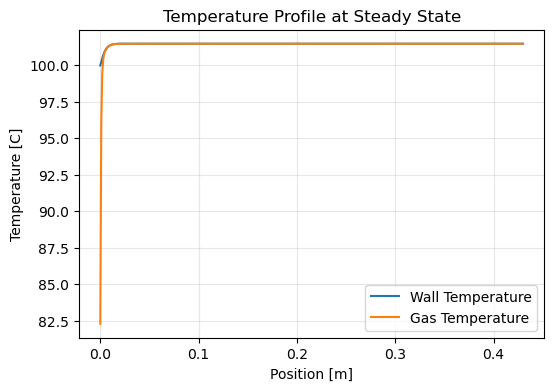

In [215]:
plt.figure(figsize=(6,4))
plt.plot(z, Tw[:,-1], label='Wall Temperature')
plt.plot(z, Tg[:,-1], label='Gas Temperature')
plt.xlabel('Position [m]')
plt.ylabel('Temperature [C]')
plt.title('Temperature Profile at Steady State')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Computing energy balance history...


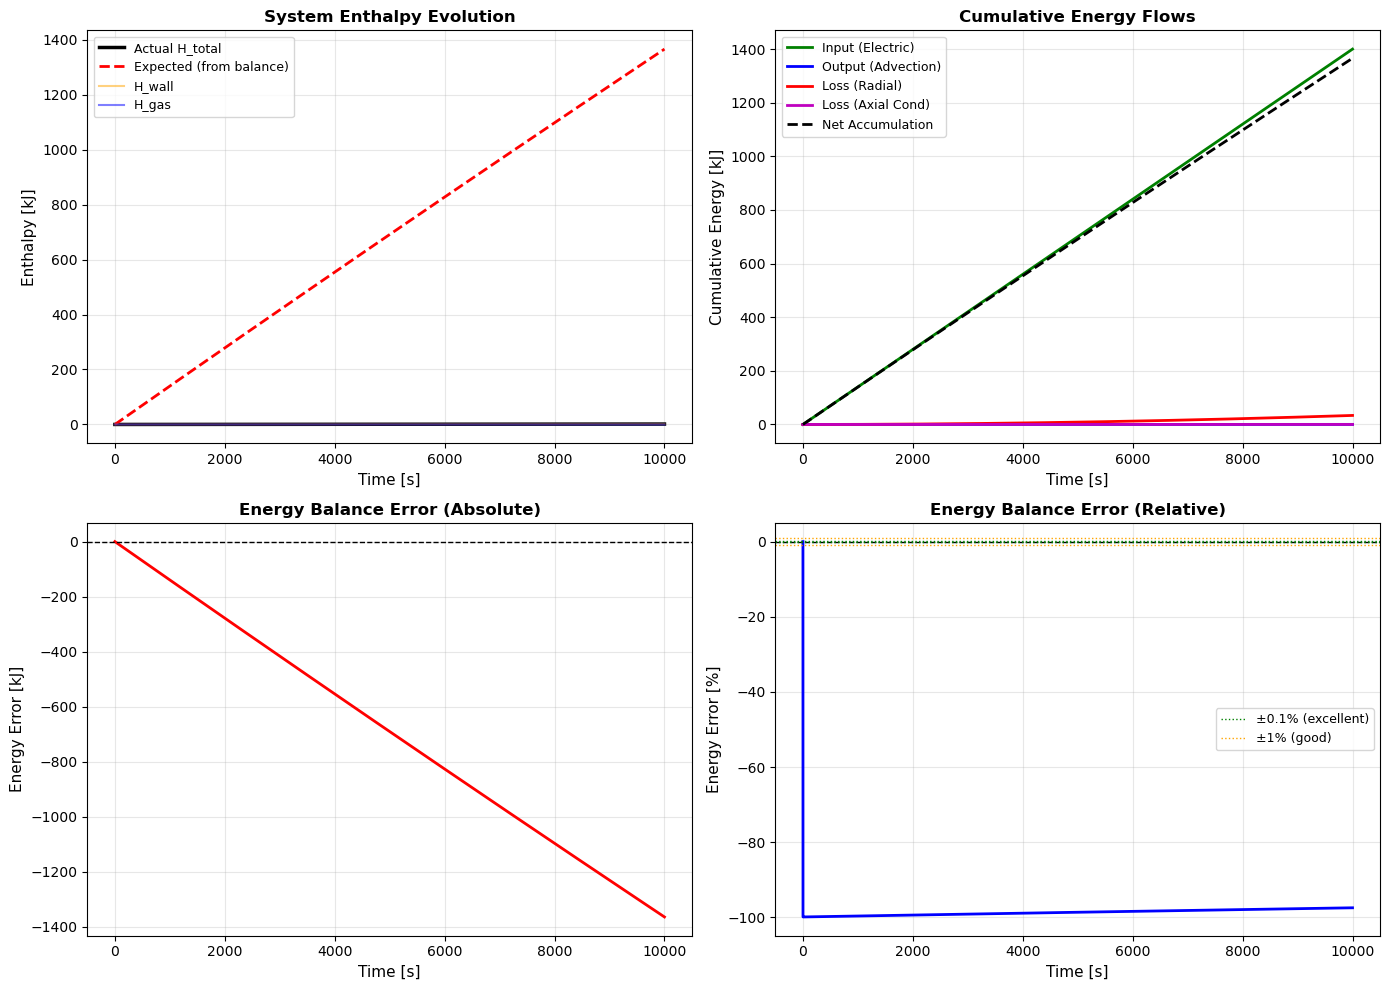


ENERGY BALANCE VALIDATION SUMMARY
Simulation time: 10000.0 s

Final System Enthalpy:
  Wall:          1.44 kJ
  Gas:           0.00 kJ
  Total:         1.44 kJ

Cumulative Energy Flows:
  Input (Electric):             1400.00 kJ
  Output (Advection):              0.30 kJ
  Loss (Radial):                  33.63 kJ
  Loss (Axial Conduction):         0.16 kJ
  Net Accumulation:             1365.90 kJ

Energy Balance Check:
  Expected ΔH:               1365.90 kJ
  Actual ΔH:                    1.44 kJ
  Error (absolute):       -1364.4671 kJ
  Error (relative):       -97.461933 %
❌ WARNING: Energy balance error >= 5% (check model)


In [216]:
# ============================================================
# Energy Balance Validation (Post-Processing)
# ============================================================

from scipy.integrate import cumulative_trapezoid

# Calculate energy fluxes and enthalpy at each time point
n_time = len(sol.t)
Q_in_inst = np.zeros(n_time)
Q_out_inst = np.zeros(n_time)
Q_loss_inst = np.zeros(n_time)
Q_cond_net_inst = np.zeros(n_time)
H_wall = np.zeros(n_time)
H_gas = np.zeros(n_time)
H_total = np.zeros(n_time)

print("Computing energy balance history...")
for i in range(n_time):
    Q_in_inst[i], Q_out_inst[i], Q_loss_inst[i], Q_cond_net_inst[i] = calculate_energy_fluxes(sol.t[i], sol.y[:, i])
    H_wall[i], H_gas[i], H_total[i] = calculate_system_enthalpy(sol.y[:, i])

# Cumulative energy flows using trapezoidal integration
Q_in_cum = cumulative_trapezoid(Q_in_inst, sol.t, initial=0)
Q_out_cum = cumulative_trapezoid(Q_out_inst, sol.t, initial=0)
Q_loss_cum = cumulative_trapezoid(Q_loss_inst, sol.t, initial=0)
Q_cond_net_cum = cumulative_trapezoid(Q_cond_net_inst, sol.t, initial=0)

# Expected enthalpy change from energy balance
# dH/dt = Q_in - Q_out - Q_loss - Q_cond_net
H_expected = H_total[0] + (Q_in_cum - Q_out_cum - Q_loss_cum - Q_cond_net_cum)

# Energy balance error
energy_error = H_total - H_expected
energy_error_pct = (energy_error / (Q_in_cum + 1e-10)) * 100

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: System Enthalpy vs Time
ax1 = axes[0, 0]
ax1.plot(sol.t, H_total/1000, 'k-', linewidth=2.5, label='Actual H_total')
ax1.plot(sol.t, H_expected/1000, 'r--', linewidth=2, label='Expected (from balance)')
ax1.plot(sol.t, H_wall/1000, 'orange', alpha=0.5, linewidth=1.5, label='H_wall')
ax1.plot(sol.t, H_gas/1000, 'blue', alpha=0.5, linewidth=1.5, label='H_gas')
ax1.set_xlabel('Time [s]', fontsize=11)
ax1.set_ylabel('Enthalpy [kJ]', fontsize=11)
ax1.set_title('System Enthalpy Evolution', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Cumulative Energy Flows
ax2 = axes[0, 1]
ax2.plot(sol.t, Q_in_cum/1000, 'g-', linewidth=2, label='Input (Electric)')
ax2.plot(sol.t, Q_out_cum/1000, 'b-', linewidth=2, label='Output (Advection)')
ax2.plot(sol.t, Q_loss_cum/1000, 'r-', linewidth=2, label='Loss (Radial)')
ax2.plot(sol.t, Q_cond_net_cum/1000, 'm-', linewidth=2, label='Loss (Axial Cond)')
ax2.plot(sol.t, (Q_in_cum - Q_out_cum - Q_loss_cum - Q_cond_net_cum)/1000, 'k--', linewidth=2, label='Net Accumulation')
ax2.set_xlabel('Time [s]', fontsize=11)
ax2.set_ylabel('Cumulative Energy [kJ]', fontsize=11)
ax2.set_title('Cumulative Energy Flows', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Energy Balance Error (Absolute)
ax3 = axes[1, 0]
ax3.plot(sol.t, energy_error/1000, 'r-', linewidth=2)
ax3.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax3.set_xlabel('Time [s]', fontsize=11)
ax3.set_ylabel('Energy Error [kJ]', fontsize=11)
ax3.set_title('Energy Balance Error (Absolute)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Energy Balance Error (Percentage)
ax4 = axes[1, 1]
ax4.plot(sol.t, energy_error_pct, 'b-', linewidth=2)
ax4.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax4.axhline(y=0.1, color='green', linestyle=':', linewidth=1, label='±0.1% (excellent)')
ax4.axhline(y=-0.1, color='green', linestyle=':', linewidth=1)
ax4.axhline(y=1, color='orange', linestyle=':', linewidth=1, label='±1% (good)')
ax4.axhline(y=-1, color='orange', linestyle=':', linewidth=1)
ax4.set_xlabel('Time [s]', fontsize=11)
ax4.set_ylabel('Energy Error [%]', fontsize=11)
ax4.set_title('Energy Balance Error (Relative)', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final energy balance summary
print("\n" + "=" * 70)
print("ENERGY BALANCE VALIDATION SUMMARY")
print("=" * 70)
print(f"Simulation time: {sol.t[-1]:.1f} s")
print(f"\nFinal System Enthalpy:")
print(f"  Wall:  {H_wall[-1]/1000:>12.2f} kJ")
print(f"  Gas:   {H_gas[-1]/1000:>12.2f} kJ")
print(f"  Total: {H_total[-1]/1000:>12.2f} kJ")
print(f"\nCumulative Energy Flows:")
print(f"  Input (Electric):        {Q_in_cum[-1]/1000:>12.2f} kJ")
print(f"  Output (Advection):      {Q_out_cum[-1]/1000:>12.2f} kJ")
print(f"  Loss (Radial):           {Q_loss_cum[-1]/1000:>12.2f} kJ")
print(f"  Loss (Axial Conduction): {Q_cond_net_cum[-1]/1000:>12.2f} kJ")
print(f"  Net Accumulation:        {(Q_in_cum[-1] - Q_out_cum[-1] - Q_loss_cum[-1] - Q_cond_net_cum[-1])/1000:>12.2f} kJ")
print(f"\nEnergy Balance Check:")
print(f"  Expected ΔH:          {(H_expected[-1] - H_total[0])/1000:>12.2f} kJ")
print(f"  Actual ΔH:            {(H_total[-1] - H_total[0])/1000:>12.2f} kJ")
print(f"  Error (absolute):     {energy_error[-1]/1000:>12.4f} kJ")
print(f"  Error (relative):     {energy_error_pct[-1]:>12.6f} %")
print("=" * 70)
if abs(energy_error_pct[-1]) < 0.1:
    print("✅ EXCELLENT: Energy balance error < 0.1%")
elif abs(energy_error_pct[-1]) < 1.0:
    print("✅ GOOD: Energy balance error < 1%")
elif abs(energy_error_pct[-1]) < 5.0:
    print("⚠️  ACCEPTABLE: Energy balance error < 5% (numerical error)")
else:
    print("❌ WARNING: Energy balance error >= 5% (check model)")
print("=" * 70)